# 多項式カーブフィッティング

PRMLの1章の簡単版をtensorflowで解いてみよう、というkoanです。
トレーニングデータとしてはsinの周辺に少しノイズで広がっているようなデータで、ここでは4次方程式でフィッティングし てみます。（PRML p7, Figure 1.4相当)

未実装のセルを適宜実装して、assertEquals()のセルがエラーにならないようにしてください。

In [1]:
from utils import assertEquals, assertTrue
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
rs = np.random.RandomState(123)

In [3]:
x_arr = np.linspace(0, 1, 10)

In [4]:
real_y = np.sin(x_arr*2*math.pi)

In [5]:
noise = rs.normal(0, 0.3, (len(x_arr)))

In [6]:
# Some assert depend on random seeds. Confirm whether properly fixed.
assertEquals(0.4954, noise[5])


### タスク1: real_yにノイズが加わった、noisy_yを求めよ。

In [2]:
# TODO: Implement here!

noisy_y = real_y + noise

In [8]:
assertTrue(noisy_y[0] != real_y[0], "Noise should be added to first element.")
assertTrue(len(noisy_y)==len(real_y), "Num of data must be match.")

# this assert is depend on random seed.
assertEquals(0.1534, noisy_y[5])

# may be wrong if you are unlucky...
# assertTrue(abs(noisy_y[5]-real_y[5]) < 0.6, "Noise should be small.")

In [16]:
plt.scatter(x_arr, real_y, marker='^')
plt.scatter(x_arr, noisy_y, marker='o')
plt.show()

# Tensorflowのモデル

$$ y = a + b*x + c*x^2 + d*x^3 + e*x^4 $$ の形でフィッティング。

a, b, c, d, eを学習する。

In [9]:
import tensorflow as tf

### placeholderの定義。xと、それに対応する教師用のラベルのyを入れるplaceholderを定義。

In [10]:
x = tf.placeholder(tf.float32)
y_label = tf.placeholder(tf.float32)

### 4次多項式の係数を定義

この係数を、lossが小さくなるようにoptimizeしていく。

In [11]:
a = tf.Variable([0.5], dtype=tf.float32)
b = tf.Variable([0.5], dtype=tf.float32)
c = tf.Variable([0.5], dtype=tf.float32)
d = tf.Variable([0.5], dtype=tf.float32)
e = tf.Variable([0.5], dtype=tf.float32)

### 今回はSessionをグローバル変数に作り、global_variables_initializerも最初に呼んでしまう

In [12]:
sess = tf.Session()

In [13]:
sess.run(tf.global_variables_initializer())

### yをデータから予測する式のグラフ

In [14]:
y_predict = a+b*x+c*x**2 + d*x**3 + e*x**4

### タスク2: lossを定義せよ。lossはラベルとpredictionの値の差の二乗の和とする。

In [3]:
# Implement Here!
loss = tf.reduce_sum((y_predict - y_label)**2)

### タスク3: sess.run()を用いて、xにx_arr[3]とx_arr[4]を入れて、y_labelにreal_y[3]とreal_y[4]を入れた時のロスを求めよ。

- 注意: noisy_yでは無くreal_yです。
- デバッグなどで、手計算した値と合うか、というのを確認する為にこういう事は良く行います。

In [4]:
# Implement Here!

actual = sess.run([loss], {x: x_arr[3:5], y_label:real_y[3:5]})

In [33]:
assertEquals(0.3083, actual[0])
assertEquals(1, len(actual))

### タスク4: lossを最小化する為のオペレーションのグラフを構築せよ。

ヒント: tf.train.GradientDescentOptimizerを使う。learning rateは0.01で。


In [5]:
# TODO: implement here!

train_op = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

### タスク5: train_opをx_arr[3]とnoisy_y[3]に対して、2回実行せよ

In [64]:
# Implement Here.
_ = sess.run([train_op], {x: x_arr[3], y_label: noisy_y[3]})
_ = sess.run([train_op], {x: x_arr[3], y_label: noisy_y[3]})

In [66]:
[res_a], [res_b], [res_c], [res_d] = sess.run([a, b, c, d])

In [67]:
target = x_arr[3]
original_loss = 0.5 + 0.5*target + 0.5*target**2 + 0.5*target**3
cur_loss = res_a+res_b*target+res_c*target**2+res_d*target**3

In [69]:
assertTrue(cur_loss < original_loss)

In [71]:
# 元のロスよりは小さくなっているはず
original_loss, cur_loss

(0.7407407407407407, 0.71878326270315374)

In [94]:
# real_yでのトレーニング結果をリセット

sess.run(tf.global_variables_initializer())

### トレーニング

In [95]:
all_losses = []
for epoch in range(1000):
    res_loss, res_train, [res_a], [res_b], [res_c], [res_d] = sess.run([loss, train_op, a, b, c, d], {x: x_arr, y_label: noisy_y})
    all_losses.append(res_loss)

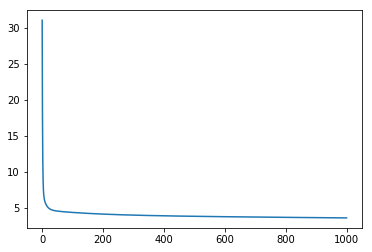

In [96]:
plt.plot(all_losses)
plt.show()

### タスク6: res_a, res_b, res_c, res_dとx_arrを使って、（numpyで）predictionの結果の配列、pred_arrを作れ

In [97]:
# TODO: Implement Here!
pred_arr = res_a+res_b*x_arr**2+res_c*x_arr**3+res_d*x_arr**4

In [98]:
assertEquals(0.682, pred_arr[0])
assertEquals(0.498, pred_arr[3])

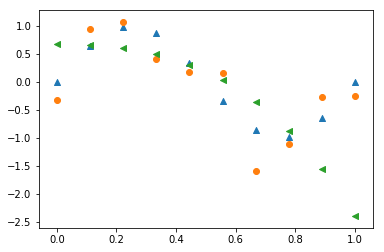

In [99]:
plt.scatter(x_arr, real_y, marker='^')
plt.scatter(x_arr, noisy_y, marker='o')
plt.scatter(x_arr, pred_arr, marker='<')
plt.show()

### 自分の雑感

4次なら三次のケースを含むはずなので、もっと良い形にフィッティング出来ても良さそう。
だが、サンプル数が少ないのでこの点の数ではトレーニングを凄く繰り返してもあまり綺麗にフィッティングしない（最後の方のずれが大きくなる）。

サンプル数を100倍くらに増やしてトレーニングしたらもっと良くなりそうなので誰か試したら結果のグラフ見せてください。